# Normalizing Flows

The VAE was our first example of a generative model that is capable of sampling from $P(x)$. The VAE has two disadvantages though. The first that you cannot numerically evaluate $P(x)$, the probability of a single point. The second disadvantage is that training the VAE is difficult, especially because you're assuming the latent space should be normal. **Generative adversarial networks** (GANs) are similar to VAEs and have the same two disadvantages.

A **normalizing flow** is similar to a VAE in that we try to build up $P(x)$ by starting from a simple known distribution $P(z)$. We use functions, like the decoder from a VAE, to go from $x$ to $z$. However, we make sure that the functions we choose keep the probability mass normalized ($\sum P(x) = 1$) and can be used forward (to sample from x) and backward (to compute $P(x)$). We call these functions **bijectors** because they are bijective (1 to 1, onto). An example of a bijector is an element-wise cosine $y_i = \cos x_i$ and non-bijective function would be any reduction $y = \sum_i x_i$. Any function which changes dimension is automatically not bijective. A consequence of using only bijectors in constructing our normalizing flow is that the size of the latent space must be equal to the size of the feature space. Remember the VAE used a smaller latent space than the feature space. 

You can find a recent review of normalizing [flows here](https://arxiv.org/pdf/1908.09257.pdf) {cite}`kobyzev2020normalizing` and [here](https://arxiv.org/abs/1912.02762){cite}`papamakarios2019normalizing`. Although generating images and sound is the most popular application of normalizing flows, some of their biggest scientific impact has been on more efficient sampling from posteriors or likelihoods and other complex probability distributions {cite}`papamakarios2019sequential`. You find details on how to do normalizing flows on categorical (discrete) data in Hoogeboom et al. {cite}`hoogeboom2021argmax`.

## Flow Equation

Recall for the VAE decoder, we had an explicit formula for $p(x | z)$. This allowed us to compute $p(x) = \int\,dz p(x | z)p(z)$ which is the quantity of interest. The VAE decoder is a conditional probability density function. In the normalizing flow, we do not use probability density functions. We use bijective functions. So we cannot just compute an integral to change variables. We can use the change of variable formula. Consider our normalizing flow to be defined by our bijector $x = f(z)$, its inverse $z = g(x)$, and the starting probability distribution $P_z(z)$. Then the formula for probability of $x$ is

\begin{equation}
P(x) = P_z\left(g(x)\right) \,\left| \textrm{det}\left[\mathbf{J}_g\right]\right|
\end{equation}

where the term on the right is the absolute value of the determinant of the Jacobian of $g$. [Jacobians](https://en.wikipedia.org/wiki/Jacobian_matrix_and_determinant) are matrices that describe how infinitesimal changes in each domain dimension change each range dimension. This term corrects for the volume change of the distribution. For example, if $f(z) = 2z$, then $g(x) = x / 2$, and the Jacobian determinant is $1 / 2$. The intuition is that we are stretching out $z$ by 2, so we need to account for the increase in volume to keep the probability normalized. You can read more about the change of variable formula for [probability distributions here](https://cranmer.github.io/stats-ds-book/distributions/change-of-variables.html)


## Bijectors

A bijector is a function that is [injective](https://en.wikipedia.org/wiki/Injective_function) (1 to 1) and surjective [https://en.wikipedia.org/wiki/Surjective_function] (onto). An equivalent way to view a bijective function is if it has an inverse. For example, a sum reduction has no inverse and is thus not bijective. $\sum [1,0] = 1$ and $\sum [-1, 2] = 1$. Multiplying by a matrix which has an inverse is bijective. $y = x^2$ is not bijective, since $y = 4$ has two solutions. 

Remember that we must compute the determinant of the bijector Jacobian. If the Jacobian is dense (all output elements depend on all input elements), computing this quantity will be $O\left(|x|_0^3\right)$ where $|x|_0$ is the number of dimensions of $x$ because a determinant scales by $O(n^3)$. This would make computing normalizing flows impractical in high-dimensions. However, in practice we restrict ourselves to bijectors that have easy to calculate Jacobians. For example, if the bijector is $x_i = \cos z_i$ then the Jacobian will be diagonal. Typically, the trick that is done is to make the Jacobian triangular. Then $x_0$ only depends on $z_0$, $z_1$ depends on $z_0, Z_1$, and $x_2$ depends on $z_0, z_1, z_2$, etc. The matrix determinant is then computed in linear time with respect to the number of dimensions.

### Bijector Chains

Just like in deep neural networks, multiple bijectors are chained together to increase how complex of the final fit distribution $\hat{P}(x)$ can be. The change of variable equation can be repeatedly applied:

\begin{equation}
P(x) = P_z\left[g_1\left(g_0(x)\right)\right] \,\left| \textrm{det}\left[\mathbf{J}_{g_1}\right]\right|  \left|\textrm{det}\left[\mathbf{J}_{g_0}\right]\right|
\end{equation}

where we would compute $x$ with $f_0\left(f_1(z)\right)$. One critical point is that you should also include a **permute bijector** that swaps the order of dimensions. Since the bijectors typically have triangular Jacobians, certain output dimensions will depend on many input dimensions and others will only depend on a single one. By applying a permutation, you allow each dimension to influence each other.


## Training

At this point, you may be wondering how you could possibly train a normalizing flow. The trainable parameters appear in the bijectors. They have adjustable parameters. The loss equation is quite simple: the negative log-likelihood (negative to make it minimization). Explicitly:

\begin{equation}
\mathcal{l} = -\log P_z\left[g_1\left(g_0(x)\right)\right] - \sum_i \log\left| \textrm{det}\left[\mathbf{J}_{g_i}\right]\right|
\end{equation}

where $x$ is the training point and when you take the gradient of the loss, it is with respect to the parameters of the bijectors. 


## Common Bijectors

The choice of bijector functions is a fast changing area. I will thus only mention a few. You can of course use any bijective function or matrix, but these become inefficient at high-dimension due to the Jacobian calculation. One class of efficient bijectors are autoreggresive bijectors. These have triangular Jacobians because each output dimension can only depend on the dimensions with a lower index. There are two variants: masked autoregressive flows (MAF){cite}`papamakarios2017masked` and inverse autoreggresive flows (IAF) {cite}`kingma2016improved`. MAFs are efficient at training and computing probabilities, but are slow for sampling from $P(x)$. IAFs are slow at training and computing probabilities but efficient for sampling. Wavenets combine the advantages of both {cite}`kim2018flowavenet`. I'll mention one other common bijector which is not autoregressive: real non-volume preserving (RealNVPs) {cite}`dinh2016density`. RealNVPs are less expressive than IAFs/MAFs, meaning they have trouble replicating complex distributions, but are efficient at all three tasks: training, sampling, and computing probabilities. Another interesting variant is the Glow bijector,which is able to expand the rank of the normalizing flow, for example going from a matrix to an RGB image {cite}`das2019dimensionality`. What are the equations for all these bijectors? Most are variants of standard neural network layers but with special rules about which outputs depend on which inputs. 


```{warning}
Remember to add permute bijectors between autoregressive bijectors to ensure the dependence between dimensions is well-mixed.
```


## Running This Notebook


Click the &nbsp;<i aria-label="Launch interactive content" class="fas fa-rocket"></i>&nbsp; above to launch this page as an interactive Google Colab. See details below on installing packages, either on your own environment or on Google Colab

````{tip} My title
:class: dropdown
To install packages, execute this code in a new cell

```
!pip install matplotlib numpy tesnorflow-probability
```

````

The hidden code below imports the tensorflow probability package and other necessary packages. Note that the tensorflow probability package (`tfp`) is further broken into distributions (`tfd`) and bijectors (`tfb`). 

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import sklearn.datasets as datasets
import numpy as np
import seaborn as sns
import matplotlib as mpl
sns.set_context('notebook')
sns.set_style('dark',  {'xtick.bottom':True, 'ytick.left':True, 'xtick.color': '#666666', 'ytick.color': '#666666',
                        'axes.edgecolor': '#666666', 'axes.linewidth':     0.8 , 'figure.dpi': 300})
color_cycle = ['#1BBC9B', '#F06060', '#5C4B51', '#F3B562', '#6e5687']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=color_cycle) 

tfd = tfp.distributions
tfb = tfp.bijectors

## Moon Example

We'll start with a basic 2D example to learn the two moon's distribution with a normalizing flow. When doing normalizing flows you have two options to implement them. You can do all the Jacobians, inverses, and likelihood calculations analytically and implement them in a normal ML framework like Jax, PyTorch, or TensorFlow. This is actually most common. The second option is to utilize a probability library that knows how to use bijectors and distributions. The packages for that are PYMC3, TensorFlow Probability (which has a non-tensorflow JAX version confusingly), and Pyro (Pytorch). We'll use TensorFlow Probability for this work. 

### Generating Data

In the code below, I set-up my imports and sample points which will be used for training. Remember, this code has nothing to do with normalizing flows -- it's just to generate data.

In [2]:
moon_n = 10000
ndim = 2
data, _ = datasets.make_moons(moon_n, noise=0.05)

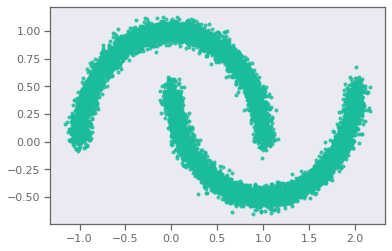

In [3]:
plt.plot(data[:,0], data[:,1], '.', alpha=0.8)

### Z Distribution

Our Z distribution should always be as simple as possible. I'll create a 2D Gaussian with unit variance, no covariance, and centered at 0. I'll be using the tensorflow probability package for this example. The key new concept is that we organize our tensors that were *sampled* from a probability distribution in a specific way. We, by convention, make the first axes be the **sample** shape, the second axes be the **batch** shape, and the final axes be the **event** shape. The sample shape is the number of times we sampled from our distribution. It is a *shape* and not a single dimension because occasionally you'll want to organize your samples into some shape. The batch shape is a result of possibly multiple distributions batched together. For example, you might have 2 Gaussians, instead of a single 2D Gaussian. Finally, the event shape is the shape of a single sample from the distribution. This is overly complicated for our example, but you should be able to read information about the distribution now by understanding this nomenclature. You can find a tutorial on these [shapes here](https://www.tensorflow.org/probability/examples/Understanding_TensorFlow_Distributions_Shapes) and more tutorials on [tensorflow probability here](https://www.tensorflow.org/probability/examples/A_Tour_of_TensorFlow_Probability). 

In [4]:
zdist = tfd.MultivariateNormalDiag(loc=[0.] * ndim)
zdist

<tfp.distributions.MultivariateNormalDiag 'MultivariateNormalDiag' batch_shape=[] event_shape=[2] dtype=float32>

With our new understanding of shapes, you can see that this distribution has no `batch_shape` because there is only one set of parameters and the `event_shape` is `[2]` because it's a 2D Gaussian. Let's now sample from this distribution and view it

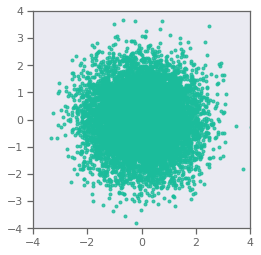

In [5]:
zsamples = zdist.sample(moon_n)
plt.plot(zsamples[:,0], zsamples[:,1], '.', alpha=0.8)
plt.xlim(-4,4)
plt.ylim(-4,4)
plt.gca().set_aspect('equal')

As expected, our starting distribution looks nothing like are target distribution. Let's demonstrate a bijector now. We'll implement the following bijector:

$$
x = \vec{z} \times (1, 0.5)^T + (0.5, 0.25)
$$

This is bijective because the operations are element-wise and invertible. Rather than just write this out using operations like `@` or `*`, we'll use the built-in bijectors from TensorFlow probability. The reason we do this is that they have their inverses and Jacobian determinants already defined. 

In [6]:
sb = tf.linalg.LinearOperatorDiag([1, 0.5])
b = tfb.AffineLinearOperator(scale=sb, shift=[0.5, 0.25])


Instructions for updating:
`AffineLinearOperator` bijector is deprecated; please use `tfb.Shift(loc)(tfb.ScaleMatvecLinearOperator(...))`.


To now apply the change of variable formula, we create a **transformed distribution**. What is important about this choice is that we can compute likelihoods, probabilities, and sample from it.

In [7]:
td = tfd.TransformedDistribution(zdist, bijector=b)
td

<tfp.distributions.TransformedDistribution 'affine_linear_operatorMultivariateNormalDiag' batch_shape=[] event_shape=[2] dtype=float32>

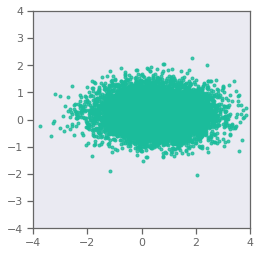

In [8]:
zsamples = td.sample(moon_n)
plt.plot(zsamples[:,0], zsamples[:,1], '.', alpha=0.8)
plt.xlim(-4,4)
plt.ylim(-4,4)
plt.gca().set_aspect('equal')

We show above the sampling from this new distribution. We can also plot it's probability, which is impossible for a VAE-like model!

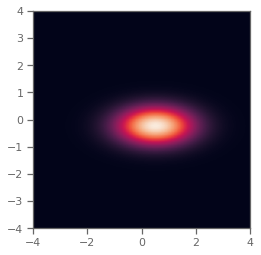

In [9]:
# make points for grid
zpoints = np.linspace(-4, 4, 150)
z1, z2, = np.meshgrid(zpoints, zpoints)
zgrid = np.concatenate((z1.reshape(-1, 1), z2.reshape(-1,1)), axis=1)
# compute P(x) 
p = np.exp(td.log_prob(zgrid))
fig = plt.figure()
# plot and set axes limits
plt.imshow(p.reshape(z1.shape), aspect='equal', extent=[-4,4, -4, 4])
plt.show()


### The Normalizing Flow

Now we will build bijectors that are expressive enough to capture the moon distribution. I will use 3 sets of a MAF and permutation for 6 total bijectors. MAF's have dense neural network layers in them, so I will also set the usual parameters for a neural network: dimension of hidden layer and activation. 

In [10]:
num_layers = 3
my_bijects = []
# loop over desired bijectors and put into list
for i in range(num_layers):
    # Syntax to make a MAF
    anet = tfb.AutoregressiveNetwork(params=ndim, hidden_units=[128, 128], activation='relu')    
    ab = tfb.MaskedAutoregressiveFlow(anet)
    # Add bijector to list
    my_bijects.append(ab)
    # Now permuate (!important!)
    permute = tfb.Permute([1, 0])
    my_bijects.append(permute)
# put all bijectors into one "chain bijector"
# that looks like one 
big_bijector = tfb.Chain(my_bijects)
# make transformed dist
td = tfd.TransformedDistribution(zdist, bijector=big_bijector)

At this point, we have not actually trained but we can still view our distribution. 

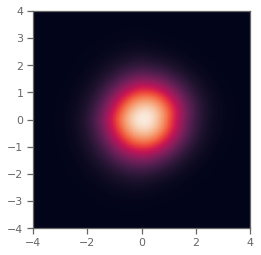

In [11]:
zpoints = np.linspace(-4, 4, 150)
z1, z2, = np.meshgrid(zpoints, zpoints)
zgrid = np.concatenate((z1.reshape(-1, 1), z2.reshape(-1,1)), axis=1)
p = np.exp(td.log_prob(zgrid))
fig = plt.figure()
plt.imshow(p.reshape(z1.shape), aspect='equal', extent=[-4,4, -4, 4])
plt.show()


You can already see that the distribution looks more complex than a Gaussian. 

### Training
To train, we'll use TensorFlow Keras, which just handles computing derivatives and the optimizer. 

In [12]:
# declare the feature dimension
x = tf.keras.Input(shape=(2,), dtype=tf.float32)
# create a "placeholder" function 
# that will be model output
log_prob = td.log_prob(x)
# use input (feature) and output (log prob)
# to make model
model = tf.keras.Model(x, log_prob)
# define a loss
def neg_loglik(yhat, log_prob):
    # losses always take in label, prediction
    # in keras. We do not have labels,
    # but we still need to accept the arg
    # to comply with Keras format
    return -log_prob
# now we prepare model for training
model.compile(optimizer=tf.optimizers.Adam(1e-2), loss=neg_loglik)

One detail is that we have to create fake labels (zeros) because Keras expects there to always be training labels. Note our loss we defined above (negative log-likelihood) takes in the labels but does nothing with them. 

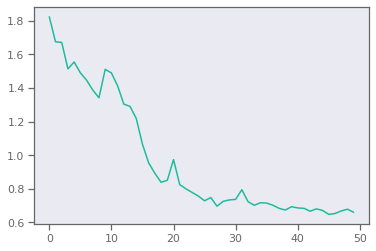

In [13]:
result = model.fit(x=data, y=np.zeros(moon_n), epochs=50, verbose=0)
plt.plot(result.history['loss'])
plt.show()

Training looks reasonable. Let's now see our distribution. 

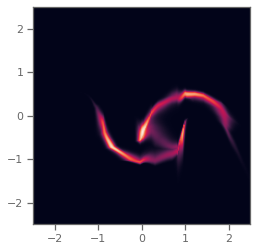

In [14]:
zpoints = np.linspace(-2.5, 2.5, 200)
z1, z2, = np.meshgrid(zpoints, zpoints)
zgrid = np.concatenate((z1.reshape(-1, 1), z2.reshape(-1,1)), axis=1)
p = np.exp(td.log_prob(zgrid))
fig = plt.figure()
plt.imshow(p.reshape(z1.shape), aspect='equal', extent=[-2.5,2.5, -2.5, 2.5])
plt.show()


Wow! We now can compute the probability of any point in this distribution. You can see there are some oddities that could be fixed with further training. One issue that cannot be overcome is the connection between the two curves -- it is not possible to get fully disconnected densities. This is because of our requirement that the bijectors are invertible and volume preserving -- you can only squeeze volume so far but cannot completely disconnect. Some work has been done on addressing this issue by adding sampling to the flow and this gives more expressive normalizing flows {cite}`wu2020stochastic`.

Finally, we'll sample from our model just to show that indeed it is generative.

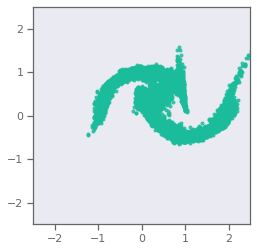

In [18]:
zsamples = td.sample(moon_n)
plt.plot(zsamples[:,0], zsamples[:,1], '.', alpha=0.8)
plt.xlim(-2.5, 2.5)
plt.ylim(-2.5,2.5)
plt.gca().set_aspect('equal')

## Relevant Videos

### Normalizing Flow for Molecular Conformation

<iframe width="560" height="315" src="https://www.youtube-nocookie.com/embed/XhAP2VNPVhg" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

## Chapter Summary 

* A normalizing flow builds up a probability distribution of $x$ by starting from a known distribution on $z$. Bijective functions are used to go from $z$ to $x$.
* Bijectors are functions that keep the probability mass normalized and are used to go forward and backward (because they have well-defined inverses).
* To find the probability distribution of $x$ we use the change of variable formula, which requires a function inverse and Jacobian.
* The bijector function has trainable parameters, which can be trained using a negative log-likelihood function. 
* Multiple bijectors can be chained together, but typically must include a permute bijector to swap the order of dimensions. 

## Cited References

```{bibliography}
:style: unsrtalpha
:filter: docname in docnames
```